In [9]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv("../data/logfile-v4.csv", delimiter=";")
dataset.head()

,time,datacenter_name,host_id,type,active,number_of_pes,available_pes,mips,available_mips,ram,available_ram,bw,available_bw,power_model,vms,Unnamed: 15
0,300.01,Datacenter_1,0,host,True,4,1,10000,0.0,160000,83880.0,10000,111.0,"93.7,97.0,101.0,105.0,110.0,116.0,121.0,125.0,...","2,1000.0,8388.0,12.0:2,1000.0,8388.0,12.0:2,10...",NaN
1,600.01,Datacenter_1,0,host,True,4,1,10000,0.0,160000,83880.0,10000,111.0,"93.7,97.0,101.0,105.0,110.0,116.0,121.0,125.0,...","2,1000.0,8388.0,12.0:2,1000.0,8388.0,12.0:2,10...",NaN
2,900.01,Datacenter_1,0,host,True,4,1,10000,0.0,160000,83880.0,10000,111.0,"93.7,97.0,101.0,105.0,110.0,116.0,121.0,125.0,...","2,1000.0,8388.0,12.0:2,1000.0,8388.0,12.0:2,10...",NaN
3,1200.01,Datacenter_1,0,host,True,4,1,10000,0.0,160000,83880.0,10000,111.0,"93.7,97.0,101.0,105.0,110.0,116.0,121.0,125.0,...","2,1000.0,8388.0,12.0:2,1000.0,8388.0,12.0:2,10...",NaN
4,1500.01,Datacenter_1,0,host,True,4,1,10000,0.0,160000,83880.0,10000,111.0,"93.7,97.0,101.0,105.0,110.0,116.0,121.0,125.0,...","2,1000.0,8388.0,12.0:2,1000.0,8388.0,12.0:2,10...",NaN


### Workload placement

#### Current workload placement

Host ID '0' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '1' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '2' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '3' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '4' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '5' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '6' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '7' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '8' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '9' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '10' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '11' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '12' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '13' at datacenter 'Datacenter_1' has 10 running workloads.
Host ID '14' at datacenter 'Datacenter_1' has 10 running w

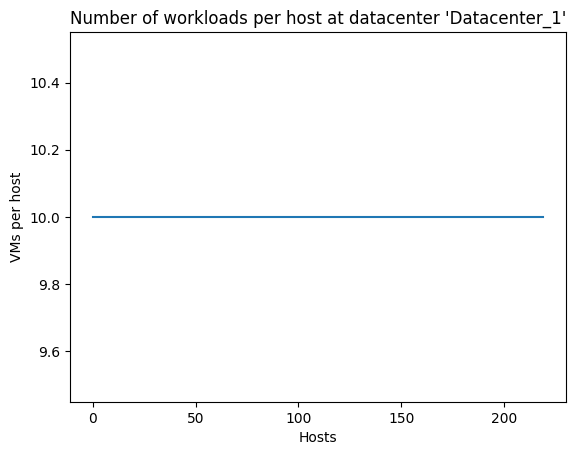

Host ID '0' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '1' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '2' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '3' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '4' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '5' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '6' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '7' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '8' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '9' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '10' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '11' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '12' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '13' at datacenter 'Datacenter_2' has 10 running workloads.
Host ID '14' at datacenter 'Datacenter_2' has 10 running w

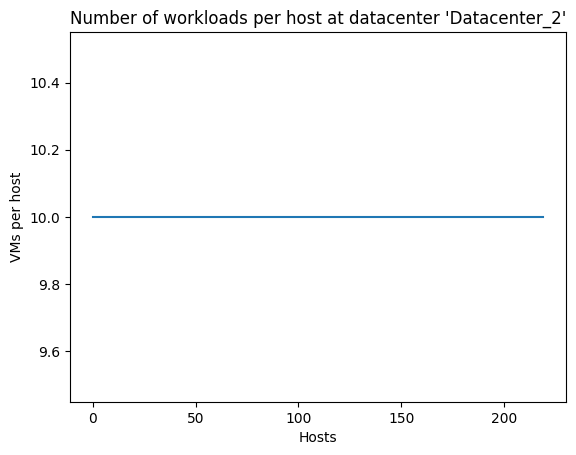

Host ID '0' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '1' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '2' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '3' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '4' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '5' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '6' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '7' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '8' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '9' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '10' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '11' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '12' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '13' at datacenter 'Datacenter_3' has 10 running workloads.
Host ID '14' at datacenter 'Datacenter_3' has 10 running w

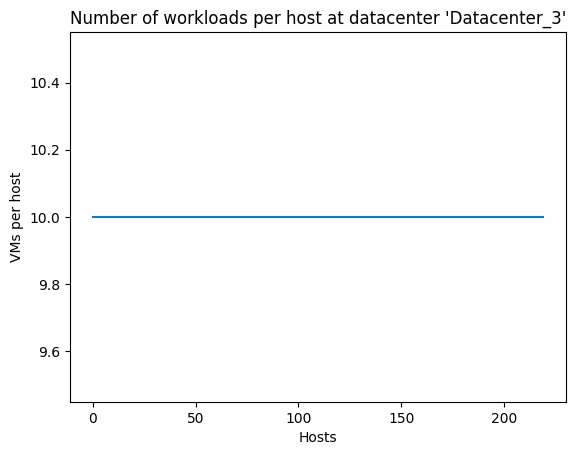

Host ID '0' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '1' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '2' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '3' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '4' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '5' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '6' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '7' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '8' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '9' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '10' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '11' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '12' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '13' at datacenter 'Datacenter_4' has 10 running workloads.
Host ID '14' at datacenter 'Datacenter_4' has 10 running w

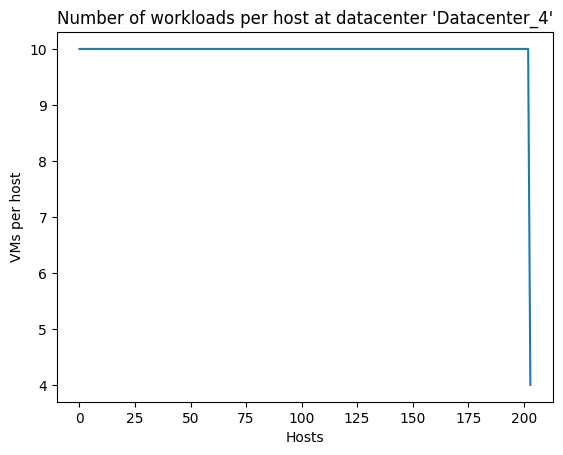

2200.0 Workloads at datacenter 'Datacenter_1'.
2200.0 Workloads at datacenter 'Datacenter_2'.
2200.0 Workloads at datacenter 'Datacenter_3'.
2034.0 Workloads at datacenter 'Datacenter_4'.
The cloud provider has 8634.0 workloads running.


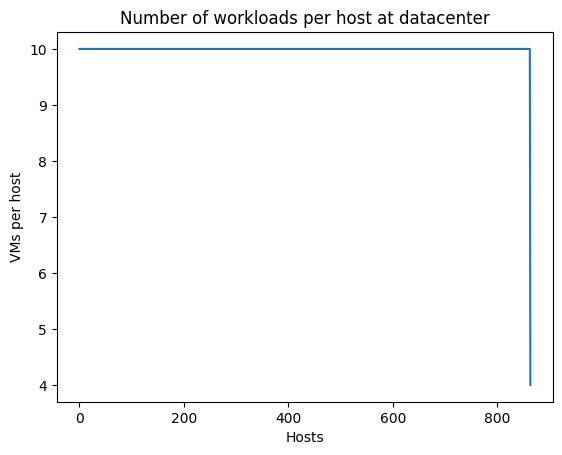

There are 16 powered down hosts.


In [10]:
labels = np.unique(dataset['datacenter_name'])
workload_per_datacenter = np.array([])
workload_per_host = np.array([])
num_powered_down_hosts = 0
for i in range(len(labels)):
    workload_per_datacenter_per_host = np.array([])
    
    for index, sample in dataset[(dataset['datacenter_name'] == labels[i]) & (dataset['time'] == 300.01)].iterrows():
        if sample['active'] == False:
            num_powered_down_hosts += 1
        if pd.notna(sample['vms']):
            workloads = len(sample['vms'].split(":"))-1
            print(f"Host ID '{sample['host_id']}' at datacenter '{sample['datacenter_name']}' has {workloads} running workloads.")
            workload_per_host = np.append(workload_per_host, len(sample['vms'].split(":"))-1)
            workload_per_datacenter_per_host = np.append(workload_per_datacenter_per_host, len(sample['vms'].split(":"))-1)
    workload_per_datacenter = np.append(workload_per_datacenter, sum(workload_per_datacenter_per_host))
    
    plt.plot(np.arange(len(workload_per_datacenter_per_host)), workload_per_datacenter_per_host, label="Workloads per host")
    plt.xlabel("Hosts")
    plt.ylabel("VMs per host")
    plt.title(f"Number of workloads per host at datacenter '{labels[i]}'")
    #plt.legend()
    plt.show()

for i in range(len(labels)):
    print(f"{workload_per_datacenter[i]} Workloads at datacenter '{labels[i]}'.")
print(f"The cloud provider has {sum(workload_per_datacenter)} workloads running.")

plt.plot(np.arange(len(workload_per_host)), workload_per_host, label="Workloads per host")
plt.xlabel("Hosts")
plt.ylabel("VMs per host")
plt.title(f"Number of workloads per host at datacenter")
#plt.legend()
plt.show()

print(f"There are {num_powered_down_hosts} powered down hosts.")

#### Simple resource aware workload placement

In [11]:

vms = []
hosts = []
for index, sample in dataset[dataset['time'] == 300.01].iterrows():
    hosts.append({
        "id": index,
        "datacenter": sample['datacenter_name'],
        "active": sample['active'],
        "power_model": sample['power_model'].split(","),
        "pes": int(sample['number_of_pes']),
        "mips": float(sample['mips']),
        "used_mips": (float(sample['mips']) - float(sample['available_mips'])),
        "ram": float(sample['ram']),
        "used_ram": (float(sample['ram']) - float(sample['available_ram'])),
        "bw": float(sample['bw']),
        "used_bw": (float(sample['bw']) - float(sample['available_bw'])),
    })
    if pd.notna(sample['vms']):
        for index, vm in enumerate(sample['vms'].split(":")):
            vm_allocated_resources = vm.split(",")
            if len(vm_allocated_resources) != 4:
                continue
            vms.append({
                "id": index,
                "pes": int(vm_allocated_resources[0]),
                "mips": float(vm_allocated_resources[1]),
                "ram": float(vm_allocated_resources[2]),
                "bw": float(vm_allocated_resources[3])
            })

vms_copy = vms.copy()
new_workloads_placement = []
for index_host, host in enumerate(hosts):
    used_mips = 0
    used_ram = 0
    used_bw = 0
    workloads_per_host = []
    
    for index_vm, vm in enumerate(vms_copy):
        if ((vm['mips'] + used_mips) <= host['mips']) and ((vm['ram'] + used_ram) <= host['ram']) and ((vm['bw'] + used_bw) <= host['bw']):
            used_mips += vm['mips']
            used_ram += vm['ram']
            used_bw += vm['bw']
            workloads_per_host.append(vm)
    
    new_workloads_placement.append(workloads_per_host)
    for index_vm, vm in enumerate(workloads_per_host):
        run = True
        index = 0
        while run:
            if vm['id'] == vms_copy[index]['id']:
                del vms_copy[index]
                run = False
            index += 1

Host ID '0' has 10 workloads running, utilizing (10000.0/10000.0) MIPS, (83880.0/160000.0) RAM, and (111.0/10000.0) Bandwidth,
 as supposed to (10000.0/10000.0) MIPS, (76120.0/160000.0) RAM, and (9889.0/10000.0) Bandwidth, 
consuming 0.135 Kilo Joules (kJ) per hour,
 with the previous workload placement consuming 0.135 Kilo Joules (kJ) per hour.

Host ID '1' has 10 workloads running, utilizing (10000.0/10000.0) MIPS, (83880.0/160000.0) RAM, and (76.0/10000.0) Bandwidth,
 as supposed to (10000.0/10000.0) MIPS, (76120.0/160000.0) RAM, and (9924.0/10000.0) Bandwidth, 
consuming 0.135 Kilo Joules (kJ) per hour,
 with the previous workload placement consuming 0.135 Kilo Joules (kJ) per hour.

Host ID '2' has 10 workloads running, utilizing (10000.0/10000.0) MIPS, (83880.0/160000.0) RAM, and (70.0/10000.0) Bandwidth,
 as supposed to (10000.0/10000.0) MIPS, (76120.0/160000.0) RAM, and (9930.0/10000.0) Bandwidth, 
consuming 0.135 Kilo Joules (kJ) per hour,
 with the previous workload placement

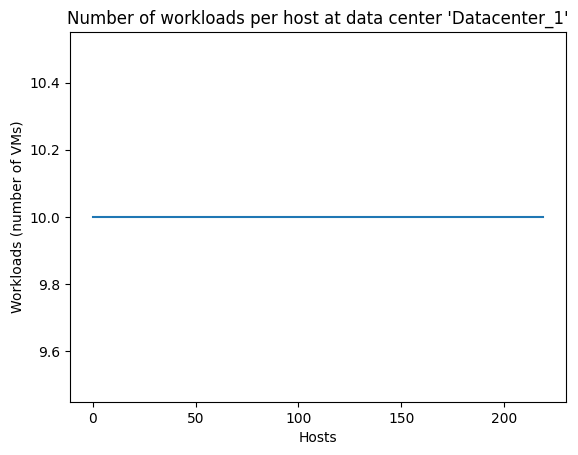

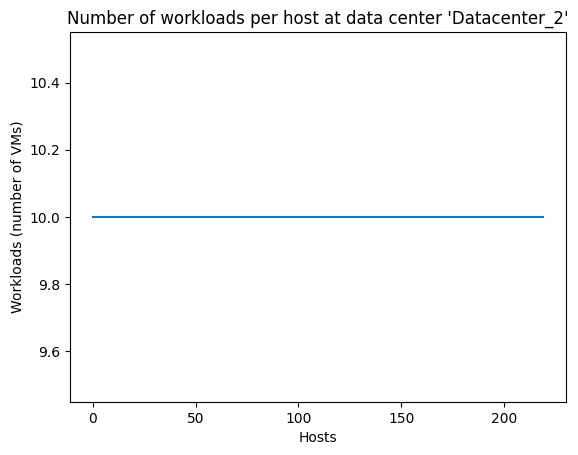

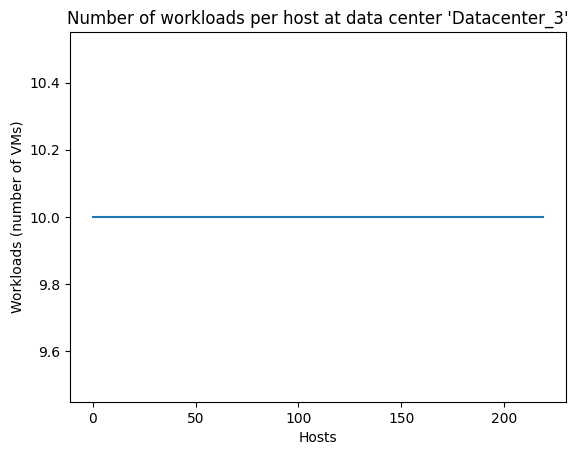

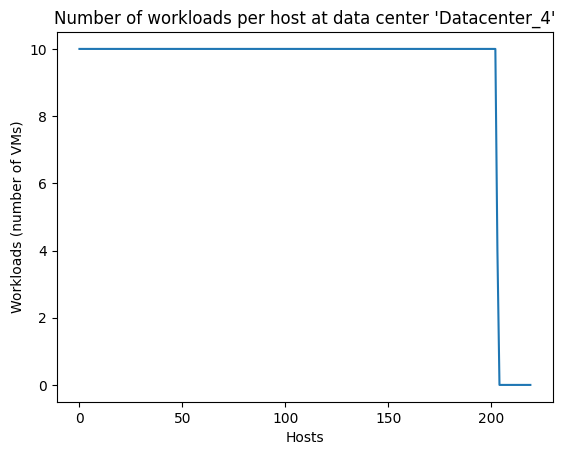

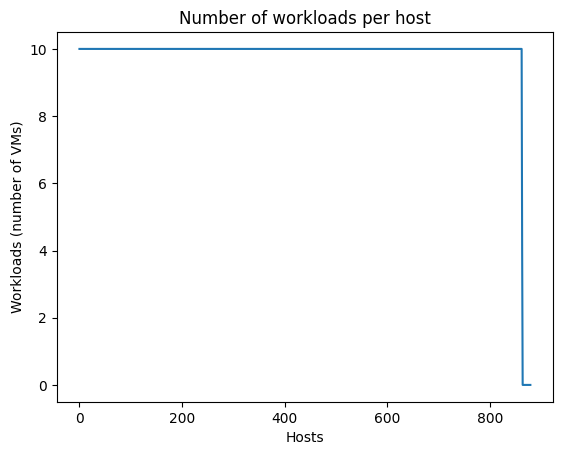

In [12]:
# Calculating the resource utilzation and the energy consumption.
new_power_per_host = np.array([])
current_power_per_host = np.array([])
new_workloads_placement_per_datacenter_per_host = {}

new_workloads_placement_per_host = np.array([])
for index_host, host in enumerate(new_workloads_placement):
    used_mips = 0
    used_ram = 0
    used_bw = 0
    vms = len(host)
    
    new_workloads_placement_per_host = np.append(new_workloads_placement_per_host, vms)
    # print(new_workloads_placement_per_datacenter_per_host.keys() in )
    # print(hosts[index_host]['datacenter'])
    # print(new_workloads_placement_per_datacenter_per_host['sd'])
    # print(new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']])
    if hosts[index_host]['datacenter'] not in new_workloads_placement_per_datacenter_per_host.keys():
        # print(new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']])
        new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']] = np.array([])
    new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']] = np.append(new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']], vms)
    
    new_host_power = 0
    current_host_power = 0
    for index_vm, vm in enumerate(host):
        used_mips += vm['mips']
        used_ram += vm['ram']
        used_bw += vm['bw']
            
    # Getting the power consumption and resource utilization of the new workload placement
    if (used_mips == 0) and (used_ram == 0) and (used_bw == 0):
        pass
    else:
        utilization = used_mips/hosts[index_host]['mips']
        if utilization % 0.1 == 0:
            new_host_power += utilization * 10
        else:
            utilization_floor = int(math.floor(utilization * 10))
            utilization_ceil = int(math.ceil(utilization * 10))
            power_floor = float(hosts[index_host]['power_model'][utilization_floor])
            power_ceil = float(hosts[index_host]['power_model'][utilization_ceil])
            
            diff = (power_ceil - power_floor) / 10
            new_host_power = power_floor + diff * (utilization - utilization_floor / 10) * 100
            new_power_per_host = np.append(new_power_per_host, new_host_power)
    
    # Getting the power consumption and resource utilization of the current workload placement
    if hosts[index_host]['active'] == False:
        pass
    else:
        utilization = hosts[index_host]['used_mips']/hosts[index_host]['mips']
        if utilization % 0.1 == 0:
            current_host_power = utilization * 10
        
        utilization_floor = int(math.floor(utilization * 10))
        utilization_ceil = int(math.ceil(utilization * 10))
        power_floor = float(hosts[index_host]['power_model'][utilization_floor])
        power_ceil = float(hosts[index_host]['power_model'][utilization_ceil])
        
        diff = (power_ceil - power_floor) / 10
        current_host_power = power_floor + diff * (utilization - utilization_floor / 10) * 100
        current_power_per_host = np.append(current_power_per_host, current_host_power)
    
    print(f"Host ID '{index_host}' has {vms} workloads running, utilizing ({used_mips}/{hosts[index_host]['mips']}) MIPS, ({used_ram}/{hosts[index_host]['ram']}) RAM, and ({used_bw}/{hosts[index_host]['bw']}) Bandwidth,\n as supposed to ({hosts[index_host]['used_mips']}/{hosts[index_host]['mips']}) MIPS, ({hosts[index_host]['used_ram']}/{hosts[index_host]['ram']}) RAM, and ({hosts[index_host]['used_bw']}/{hosts[index_host]['bw']}) Bandwidth, \nconsuming {(new_host_power * 1)/1000} Kilo Joules (kJ) per hour,\n with the previous workload placement consuming {(current_host_power * 1)/1000} Kilo Joules (kJ) per hour.\n")
print(f"Cloud provider's power consumption would then be with the new placements be {(sum(new_power_per_host) * 1)/1000} Kilo Joules per hour,\n as supposed to the previous workload placements consuming {(sum(current_power_per_host) * 1)/1000} Kilo Joules per hour.")


for key in new_workloads_placement_per_datacenter_per_host.keys():
    print()
    plt.plot(np.arange(len(new_workloads_placement_per_datacenter_per_host[key])), new_workloads_placement_per_datacenter_per_host[key], label="Workloads per host")
    plt.xlabel("Hosts")
    plt.ylabel("Workloads (number of VMs)")
    plt.title(f"Number of workloads per host at data center '{key}'")
    #plt.legend()
    plt.show()

plt.plot(np.arange(len(new_workloads_placement_per_host)), new_workloads_placement_per_host, label="Workloads per host")
plt.xlabel("Hosts")
plt.ylabel("Workloads (number of VMs)")
plt.title("Number of workloads per host")
#plt.legend()
plt.show()

#### Optimal resource aware workload placement 

In [13]:
# import itertools
# def test_1(host, vms, num):
#     results = []
#     # combinations = itertools.permutations(vms, num)
#     for combo in itertools.permutations(vms, num):
#         print("1", end="")
#         vms_utilization = {
#             "mips": 0,
#             "ram": 0,
#             "bw": 0,
#             "vms": []
#         }
#         for vm in combo:
#             vms_utilization['mips'] += vm['mips']
#             vms_utilization['ram'] += vm['ram']
#             vms_utilization['bw'] += vm['bw']
#             vms_utilization['vms'].append(vm)
#         results.append(vms_utilization)
#     return results

# tmp_vms = vms.copy()
# new_workload_list = []
# for host in hosts:
#     print("------- Host -------")
#     run = True
#     index = 1
#     prev_results = []
#     results = []
#     while run:
#         print("------- run -------")
#         num_under = 0
#         num_over = 0 
#         results = test_1(host, tmp_vms, index)
        
#         for result in results:
#             mips_utilization = (result['mips']/host['mips'])*100
#             ram_utilization = (result['ram']/host['ram'])*100
#             bw_utilization = (result['bw']/host['bw'])*100
            
#             if run == True and ((mips_utilization > 80 and mips_utilization < 90) and (ram_utilization > 80 and ram_utilization < 90) and (bw_utilization > 80 and bw_utilization < 90)): # optimal utilization (avoiding under and over utilization)
#                 print("------- optimal -------")
#                 new_workload_list.append(results['vms'])
#                 run = False
#             elif run == True and (mips_utilization < 80 and ram_utilization < 80 and bw_utilization < 80): # underutilized
#                 num_under += 1
#             elif run == True and (mips_utilization > 90 and ram_utilization > 90 and bw_utilization > 90): # overutilized
#                 num_over += 1
#         print("------- run 2 -------")
#         if run == True and num_under > num_over:
#             print("------- under -------")
#             index += 1
#             prev_results = results
#         elif run == True and num_over > num_under:
#             # picking the best out the previous results
#             print("------- over -------")
#             best = {}
#             utilization = {
#                 "mips": 0,
#                 "ram": 0,
#                 "bw": 0
#             }
#             for result in prev_results: # Could improve 
#                 mips_utilization = (result['mips']/host['mips'])*100
#                 ram_utilization = (result['ram']/host['ram'])*100
#                 bw_utilization = (result['bw']/host['bw'])*100
                
#                 if mips_utilization > utilization['mips'] and ram_utilization > utilization['ram'] and bw_utilization > utilization['bw']:
#                     best = result
#                     utilization['mips'] = mips_utilization
#                     utilization['ram'] = ram_utilization
#                     utilization['bw'] = bw_utilization
            
#             new_workload_list.append(best)
#             run = False
            
#     for vm in new_workload_list[-1]['vms']:
#         del tmp_vms[vm['id']]

In [14]:
# for index, host in enumerate(new_workload_list):
#     print(f"Host '{index}' has {len(host['vms'])} workloads")

### Re-organization of workload placement

Rebalancing over utilized and under utilized physical host with the goal if better utilizing hosts.

In [15]:
labels = np.unique(dataset['datacenter_name'])
vms_reorganized = []
hosts_reorganized = []

vms_to_reallocate = np.array([])
over_utilized_hosts = 0
under_utilized_hosts = 0

for i in range(len(labels)):
    for index, sample in dataset[(dataset['datacenter_name'] == labels[i]) & (dataset['time'] == 300.01)].iterrows():
        vms_temp = []
        if pd.notna(sample['vms']):
            for index_vm, vm in enumerate(sample['vms'].split(":")):
                    if vm != "":
                        vm_allocated_resources = vm.split(",")
                        vms_temp.append({
                            "id": index_vm,
                            "pes": int(vm_allocated_resources[0]),
                            "mips": float(vm_allocated_resources[1]),
                            "ram": float(vm_allocated_resources[2]),
                            "bw": float(vm_allocated_resources[3])
                        })
        
        # check if host is over utilized
        mips_utilization = (sample['mips'] - sample['available_mips']) / sample['mips']
        ram_utilization = (sample['ram'] - sample['available_ram']) / sample['ram']
        bw_utilization = (sample['bw'] - sample['available_bw']) / sample['bw']
        if mips_utilization > 0.9 or ram_utilization > 0.9 or bw_utilization > 0.9:
            over_utilized_hosts += 1
            if pd.notna(sample['vms']):
                #workloads = len(sample['vms'].split(":"))-1
                run = True
                for index_vm, vm in enumerate(sample['vms'].split(":")):
                    if run == True and vm != "":
                        vm_allocated_resources = vm.split(",")
                        mips_utilization = ((sample['mips'] - sample['available_mips']) - float(vm_allocated_resources[1])) / sample['mips']
                        ram_utilization = ((sample['ram'] - sample['available_ram']) - float(vm_allocated_resources[2])) / sample['ram']
                        bw_utilization = ((sample['bw'] - sample['available_bw']) - float(vm_allocated_resources[3])) / sample['bw']
                        
                        if mips_utilization >= 0.8 and mips_utilization < 0.9 and ram_utilization >= 0.8 and ram_utilization < 0.9 and bw_utilization >= 0.8 and bw_utilization < 0.9:
                            vms_to_reallocate.append(vms_temp[index_vm])
                            del vms_temp[index_vm]
                            run = False
        elif mips_utilization == 0 and ram_utilization == 0 and bw_utilization == 0:
            pass
        elif mips_utilization < 0.8 or ram_utilization < 0.8 or bw_utilization < 0.8:
            under_utilized_hosts += 1
            
    
        # hosts_reorganized.append({
        #     "id": index,
        #     "datacenter": sample['datacenter_name'],
        #     "active": sample['active'],
        #     "power_model": sample['power_model'].split(","),
        #     "pes": int(sample['number_of_pes']),
        #     "mips": float(sample['mips']),
        #     "used_mips": (float(sample['mips']) - float(sample['available_mips'])),
        #     "ram": float(sample['ram']),
        #     "used_ram": (float(sample['ram']) - float(sample['available_ram'])),
        #     "bw": float(sample['bw']),
        #     "used_bw": (float(sample['bw']) - float(sample['available_bw'])),
        #     "vms": [] 
        # })
print(f"There were {over_utilized_hosts} over utilized hosts")
print(f"There were {under_utilized_hosts} under utilized hosts")

There were 880 over utilized hosts
There were 0 under utilized hosts
